In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

# CNN model definition
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

# Load data (each client will load its own data in a real FL scenario)
def load_data(transform, datasets='MNIST'):

    train_dataset =  torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=transform)

    return train_dataset, test_dataset

# Split the dataset into 'n_clients' partitions
def partition_dataset(dataset, n_clients=10):
    split_size = len(dataset) // n_clients
    return random_split(dataset, [split_size] * n_clients)

# Client-side local training
def client_update(model, optimizer, dataloader, device, local_epochs):
    model.train()
    criterion = nn.CrossEntropyLoss()
    epoch_losses = []

    for epoch in range(local_epochs):
        total_loss = 0.0
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = model(features)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        epoch_losses.append(avg_loss)

    return epoch_losses  # return list of losses per local epoch


# Server-side aggregation of client models
def server_aggregate(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[
                                     k] for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)


# Test model on test dataset
def test_model(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

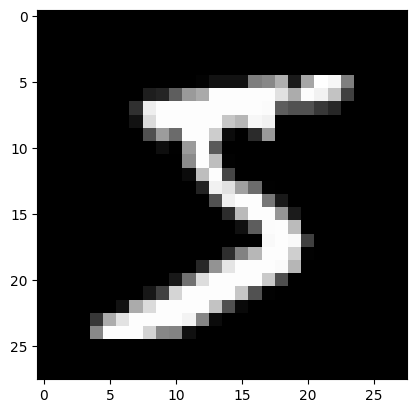

Global Epoch 1/10
Global Model Test Accuracy after round 1: 93.9500%
Global Epoch 2/10
Global Model Test Accuracy after round 2: 96.2200%
Global Epoch 3/10
Global Model Test Accuracy after round 3: 97.1600%
Global Epoch 4/10
Global Model Test Accuracy after round 4: 97.5100%
Global Epoch 5/10
Global Model Test Accuracy after round 5: 97.6400%
Global Epoch 6/10
Global Model Test Accuracy after round 6: 97.7100%
Global Epoch 7/10
Global Model Test Accuracy after round 7: 97.9200%
Global Epoch 8/10
Global Model Test Accuracy after round 8: 97.8700%
Global Epoch 9/10
Global Model Test Accuracy after round 9: 98.0200%
Global Epoch 10/10
Global Model Test Accuracy after round 10: 98.0400%
Federated learning process completed.


In [12]:
import copy

global_epochs = 10
n_clients=10
local_epochs=3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set up the data transformation and load dataset

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset, test_dataset = load_data(transform)

plt.imshow(train_dataset[0][0][0], cmap='gray')
plt.show()

# Partition the dataset for each client
client_datasets = partition_dataset(train_dataset, n_clients)
client_loaders = [DataLoader(dataset, batch_size=50, shuffle=True)
                    for dataset in client_datasets]
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Initialize global model and client models
global_model = create_lenet().to(device)
client_models = [copy.deepcopy(global_model) for _ in range(n_clients)]

# Optimizers for client models
optimizers = [torch.optim.Adam(model.parameters(), lr=0.001)
                for model in client_models]

# Federated Learning process
global_accuracies = []
client_losses_history = [[] for _ in range(n_clients)]

for global_epoch in range(global_epochs):
    print(f'Global Epoch {global_epoch + 1}/{global_epochs}')

    # Each client trains locally
    for client_idx in range(n_clients):
        losses = client_update(client_models[client_idx],
                                optimizers[client_idx],
                                client_loaders[client_idx],
                                device, local_epochs)
        client_losses_history[client_idx].append(losses)

        # Server aggregates the models
        server_aggregate(global_model, client_models)

    # Evaluate global model
    test_accuracy = test_model(global_model, test_loader, device)
    global_accuracies.append(test_accuracy)
    print(f'Global Model Test Accuracy after round {global_epoch + 1}: {test_accuracy:.4f}%')

# Save the final global model
torch.save(global_model.state_dict(), 'federated_model.pth')
print("Federated learning process completed.")

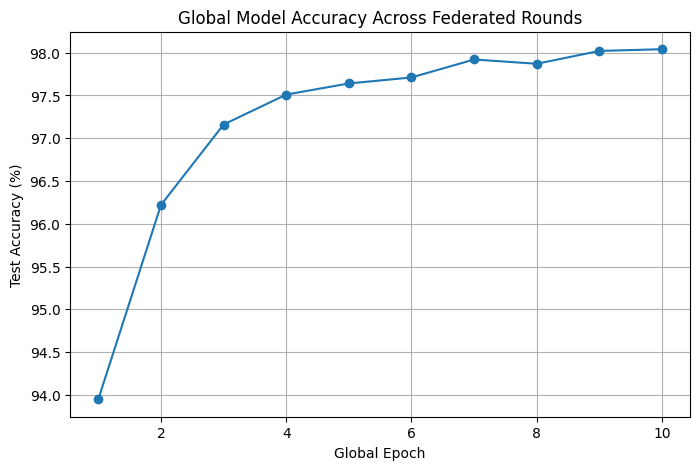

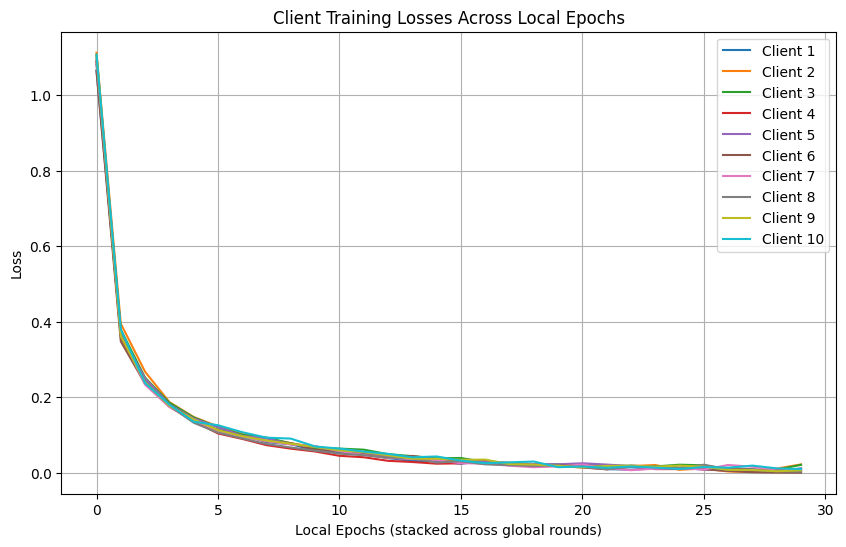

In [13]:
# Plot global accuracy

plt.figure(figsize=(8,5))
plt.plot(range(1, global_epochs+1), global_accuracies, marker='o')
plt.title("Global Model Accuracy Across Federated Rounds")
plt.xlabel("Global Epoch")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.show()

# Plot client losses
plt.figure(figsize=(10,6))
for client_idx in range(n_clients):
    # Flatten nested list of losses per global round
    client_curve = [loss for round_losses in client_losses_history[client_idx] for loss in round_losses]
    plt.plot(client_curve, label=f'Client {client_idx+1}')
plt.title("Client Training Losses Across Local Epochs")
plt.xlabel("Local Epochs (stacked across global rounds)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# loading best model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
state_dict = torch.load('federated_model.pth', weights_only=True)
global_model.load_state_dict(state_dict)

global_model.eval()
global_model.to(device)

# testing saved best model
accuracy = test_model(global_model, test_loader, device)

print("Accuracy of the loaded model：", accuracy)

Accuracy of the loaded model： 98.04
